# MNIST 3.0 - Convolutional 

This document serves as my notes on the Deep Learning Without a PhD seminar by Google. 

* [Video](https://www.youtube.com/watch?v=vq2nnJ4g6N0)
* [Slides - 1](https://docs.google.com/presentation/d/1TVixw6ItiZ8igjp6U17tcgoFrLSaHWQmMOwjlgQY9co/pub?slide=id.p)
* [Slides - 2](https://docs.google.com/presentation/d/e/2PACX-1vRouwj_3cYsmLrNNI3Uq5gv5-hYp_QFdeoan2GlxKgIZRSejozruAbVV0IMXBoPsINB7Jw92vJo2EAM/pub?slide=id.p)

This notebook covers the example of trying to classify MNIST digits with a convolutional network

# Setup

## Imports

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
import math
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## Load Data

In [2]:
# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


# Convolution

In a Convolution layer, we are having each neuron, only take a weighted sum of the pixels right above it. In this example, a neuron is taking a weighted sum of $4 \times 4$ pixels across channels. This results in a weight matrix of size $4 \times 4 \times 3$. 

![](images/conv1.png)

We can continue like this, with a neighbor neuron doing the same thing. **However, it uses the same weight matrix**. This one $4 \times 4 \times 3$ matrix (a *filter*) is *scanning* the entire. In this way (using appropriate zero padding) we end up with as many output values as we have input values:

![](images/conv2.png)

But this only has $4 \times 4 \times 3 = 48$ degrees of freedom. This is not enough! So we can just get a *different* filter, and do it again! 

![](images/conv3.png)

In tensor notation, we can write this as: 

![](images/conv4.png)

So we can now imagine **stacking** convolutional layers.

## Stride

Instead of passing our filters pixel by pixel giving us as many output values as we had input values, we could also use a **stride** value - the amount our filter moves before operating again.

It is clear that this will **reduce** the output size, as we are operating on less pixels. For example, with a stride value of $2$, we would reduce our output values by $4$. 

# Our Model

In this notebook, we will code up the following model:

![](images/conv-model.png)

**Note:** The second layer will have a $5 \times 5$ filter, not $4 \times 4$. 

**Note:** The output channels of one layer, matches the input channels of the next layer.

For clarity, we can define all our sizes upfront: 

In [3]:
batchSize = None;       # put None for right now as we dont know yet

imgHeight = 28
imgWidth = 28
numOfColors = 1         # gray scale images

numberOfClasses = 10    # 10 classes: 0-9

Now we define the size of our convolutional layers. **Note**: This corresponds to **number of different filters** we are going to use on this layer. Visually, this is the number of output/slices we produce above.

In [4]:
# Size of each layer:
sizeLayerOne = 4
sizeLayerTwo = 8
sizeLayerThree = 12

Now we define the sizes of our fully connected layer, and the output layer as before: 

In [5]:
sizeLayerFour = 200
sizeLayerFive = numberOfClasses       # the final layer is the output layer

Now we will define the stride size, according to the image above. According to [this stackoverflow question](https://stackoverflow.com/questions/34642595/tensorflow-strides-argument): 

The first 1 is the batch: You don't usually want to skip over examples in your batch, or you shouldn't have included them in the first place. :)

The last 1 is the depth of the convolution: You don't usually want to skip inputs, for the same reason.

The conv2d operator is more general, so you could create convolutions that slide the window along other dimensions, but that's not a typical use in convnets. The typical use is to use them spatially.

In [6]:
stridesL1 = [1,1,1,1]
stridesL2 = [1,2,2,1]
stridesL3 = [1,2,2,1]

As before, lets begin with our inputs and placeholders:

In [7]:
X_img = tf.placeholder(tf.float32, [batchSize, imgHeight, imgWidth, numOfColors], name="X_img")
Y_True = tf.placeholder(tf.float32, [batchSize, 10])
learningRate = tf.placeholder(tf.float32)

Now we can actually define our layers:

In [8]:
with tf.name_scope("Layer_1_Conv"):
    W1 = tf.Variable(tf.truncated_normal([5,5,1,sizeLayerOne], stddev=0.1), name="Weights")
    
    b1 = tf.Variable(tf.ones([sizeLayerOne])/10, name="Bias")
    
    Y1 = tf.nn.relu(tf.nn.conv2d(X_img, W1, strides=stridesL1, padding='SAME') + b1)

In [9]:
with tf.name_scope("Layer_2_Conv"):
    W2 = tf.Variable(tf.truncated_normal([5,5,sizeLayerOne,sizeLayerTwo], stddev=0.1), name="Weights")
    
    b2 = tf.Variable(tf.ones([sizeLayerTwo])/10, name="Bias")
    
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=stridesL2, padding='SAME') + b2)

In [10]:
with tf.name_scope("Layer_3_Conv"):
    W3 = tf.Variable(tf.truncated_normal([4,4,sizeLayerTwo,sizeLayerThree], stddev=0.1), name="Weights")
    
    b3 = tf.Variable(tf.ones([sizeLayerThree])/10, name="Bias")
    
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=stridesL3, padding='SAME') + b3)

**Note:** We need to be careful about sizes - as we can see in the image above, the result of this layer will be a $7 \times 7 \times 12$ tensor. We want to flatten this, so we need a fully connected layer with a weight matrix of size: $7 \times 7 \times \texttt{sizeLayerThree}$

In [11]:
with tf.name_scope("Layer_4_FC"):
    W4 = tf.Variable(tf.truncated_normal([7*7*sizeLayerThree,sizeLayerFour], stddev=0.1), name="Weights")
    
    b4 = tf.Variable(tf.ones([sizeLayerFour])/10, name="Bias")
    
    # flatten the last layers output
    Y3_Flat = tf.reshape(Y3, shape=[-1, 7 * 7 * sizeLayerThree], name="flatten")
    
    Y4 = tf.nn.relu(tf.matmul(Y3_Flat, W4) + b4)

In [12]:
with tf.name_scope("Output_Layer"):
    W5 = tf.Variable(tf.truncated_normal([sizeLayerFour, sizeLayerFive], stddev=0.1), name="Weights")
    
    b5 = tf.Variable(tf.ones([sizeLayerFive])/10, name="Bias")
    
    Y_logits = tf.matmul(Y4, W5) + b5
    
    Y_Pred = tf.nn.softmax(Y_logits, name="Activation")

# Training

As before:

In [13]:
# normalized cross entropy loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Y_logits, labels=Y_True)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y_Pred, 1), tf.argmax(Y_True, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training step
trainStep = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)

In [14]:
# training parameters
numberOfBatches = 10000
batchSize = 100

trainingAccuracyList = []
trainingLossList = []
testAccuracyList = []
testLossList = []

# learning rate decay
maxLearningRate = 0.003
minLearningRate = 0.0001
decaySpeed = 2000.0   # 0.003-0.0001-2000=>0.9826 done in 5000 iterations

In [15]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    # actually initialize our variables
    sess.run(init)
    
    # batch-minimization loop
    for i in range(numberOfBatches):
        # get this batches data
        batch_X, batch_Y = mnist.train.next_batch(batchSize)
        
        # calculate new learning rate for this batch:
        learning_Rate = minLearningRate + (maxLearningRate - minLearningRate) * math.exp(-i/decaySpeed)
    
        # setup this batches input dictionary
        #     - including the new learning rate
        train_data = {X_img: batch_X, Y_True: batch_Y, learningRate: learning_Rate}
        
        # run the training step on this batch
        sess.run(trainStep, feed_dict=train_data)
        
        # check our accuracy on training and test data 
        # while resetting dropout! 
        if i%100 == 0:
            # compute our success on the training data
            trainAcc, trainLoss = sess.run([accuracy, cross_entropy], feed_dict=train_data)
    
            # compute our success on the test data
            test_data = {X_img: mnist.test.images, Y_True: mnist.test.labels}
            testAcc,testLoss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
            # print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
            # print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
            
            trainingAccuracyList.append(trainAcc)
            trainingLossList.append(trainLoss)
            testAccuracyList.append(testAcc)
            testLossList.append(testLoss)
            
            print("Batch number: ",i, "lr: ", learning_Rate, "Test Loss: ", testLoss)

Batch number:  0 lr:  0.003 Test Loss:  229.864
Batch number:  100 lr:  0.0028585653310520707 Test Loss:  19.3213
Batch number:  200 lr:  0.0027240285123042826 Test Loss:  11.5417
Batch number:  300 lr:  0.0025960531316326675 Test Loss:  8.93313
Batch number:  400 lr:  0.0024743191839261473 Test Loss:  9.15171
Batch number:  500 lr:  0.002358522270907074 Test Loss:  7.68571
Batch number:  600 lr:  0.002248372839976982 Test Loss:  6.81136
Batch number:  700 lr:  0.002143595460184269 Test Loss:  6.25736
Batch number:  800 lr:  0.002043928133503354 Test Loss:  5.97276
Batch number:  900 lr:  0.001949121639703143 Test Loss:  6.21097
Batch number:  1000 lr:  0.0018589389131666372 Test Loss:  4.79135
Batch number:  1100 lr:  0.0017731544501034114 Test Loss:  5.87799
Batch number:  1200 lr:  0.001691553744672677 Test Loss:  4.44245
Batch number:  1300 lr:  0.0016139327526069466 Test Loss:  4.5172
Batch number:  1400 lr:  0.0015400973809950877 Test Loss:  3.91146
Batch number:  1500 lr:  0.001

# Plotting

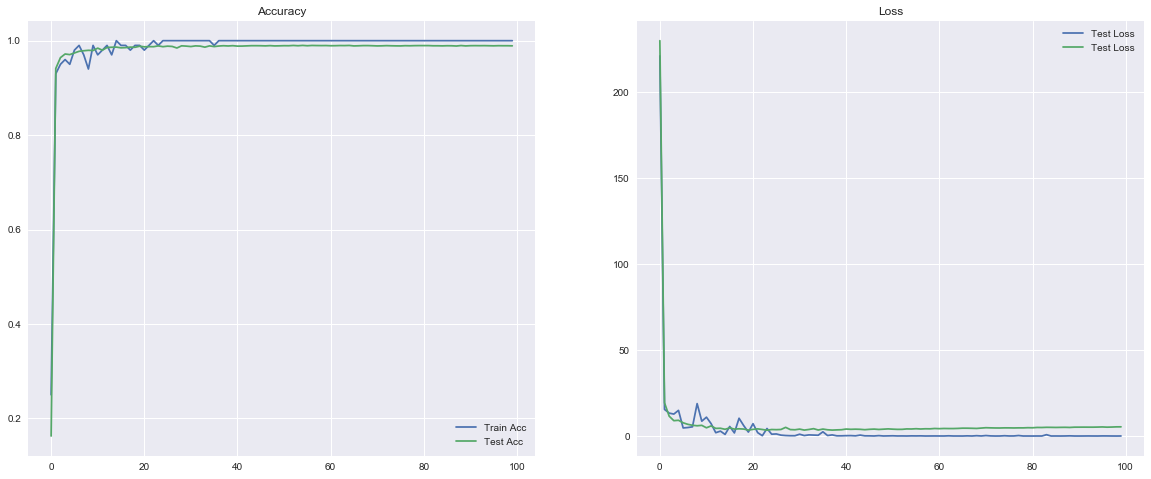

In [17]:
plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList, label="Train Acc");
plt.plot(testAccuracyList, label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Test Loss");
plt.plot(testLossList, label="Test Loss");
plt.title("Loss");
plt.legend();

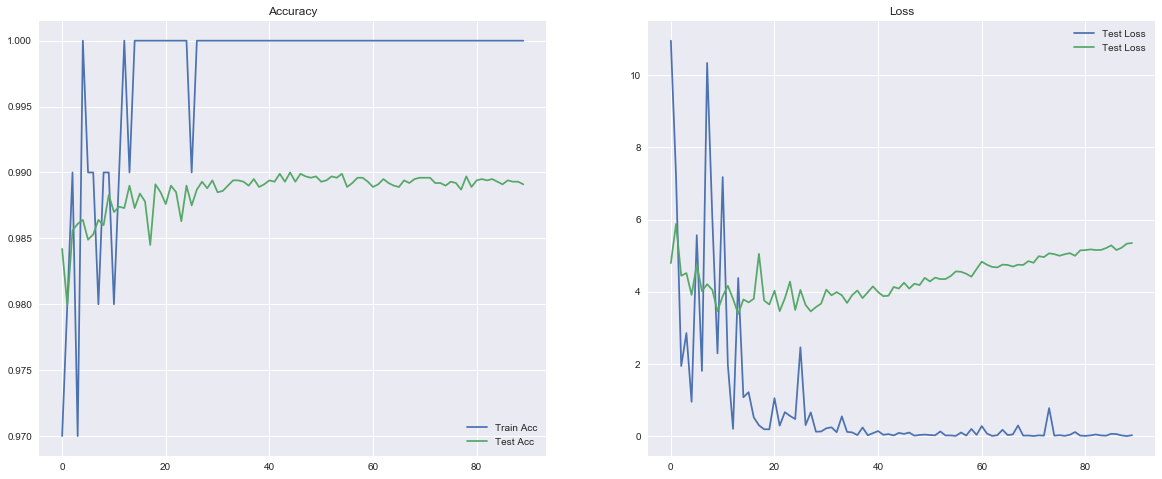

In [18]:
tailLength = -90

plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList[tailLength:], label="Train Acc");
plt.plot(testAccuracyList[tailLength:], label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList[tailLength:], label="Test Loss");
plt.plot(testLossList[tailLength:], label="Test Loss");
plt.title("Loss");
plt.legend();

# Save Results

In [19]:
resultsDic = {"trainAcc": trainingAccuracyList, "trainLoss": trainingLossList, "testAcc": testAccuracyList, "testLoss": testLossList}

with open("results/mnist-3.0-results.txt", "wb") as fp:   #Pickling
    pickle.dump(resultsDic, fp)

# Compare with Previous

In [20]:
with open("results/mnist-2.2-results.txt", "rb") as rp:
    prev_resultsDic = pickle.load(rp)

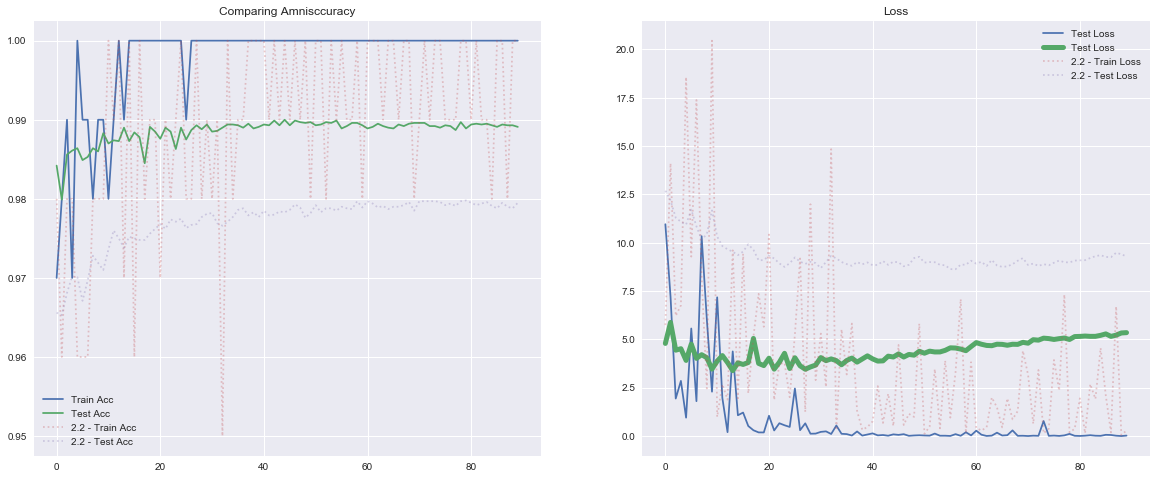

In [21]:
tailLength = -90

plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList[tailLength:], label="Train Acc");
plt.plot(testAccuracyList[tailLength:], label="Test Acc");

plt.plot(prev_resultsDic["trainAcc"][tailLength:], label="2.2 - Train Acc", alpha=0.3, linestyle=':');
plt.plot(prev_resultsDic["testAcc"][tailLength:], label="2.2 - Test Acc", alpha=0.3, linestyle=':');

plt.title("Comparing Amnisccuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList[tailLength:], label="Test Loss");
plt.plot(testLossList[tailLength:], label="Test Loss", linewidth=5);

plt.plot(prev_resultsDic["trainLoss"][tailLength:], label="2.2 - Train Loss", alpha=0.3, linestyle=':');
plt.plot(prev_resultsDic["testLoss"][tailLength:], label="2.2 - Test Loss", alpha=0.3, linestyle=':');

plt.title("Loss");
plt.legend();

So we are now almost at 99% accuracy but not quite! Notice we once again have the rise in our test error! 